## Image segmentation with CamVid

Video 1:12:30

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

This notebook shows how to do segmentation. Create here a colou coded picture, where e.g. humans and bicycles have one colour. We give shapes numbers there, like building is number 4.

This is essentially a classification problem, what class is pixel xyz?

Technically, we need a dataset where someone has labelled every pixel. This is common in medicine, life science where we have e.g. segmented cells or alike. Also common in self driving cars.

CAMVID is a common dataset with pre-prepped labelled data. 

http://people.inf.ethz.ch/aksoyy/sss/

1:30:00 Q&A
        
How do you read the learning graph? Can you not just get a number back?
So far, not possible. We need someone to experiment and interpret that graph, it depends on context. 
Then you need to iterate over it.
It is in principle possible to come up with a simple heuristic.

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_007470.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_008700.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_010320.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_07170_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_007170_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_006690_P.png')]

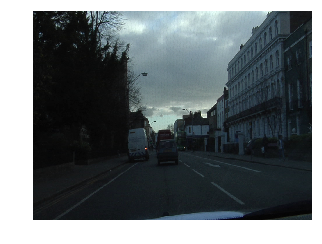

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
## goes from image file names to equivalent label file names
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}' ## takes filename, adds _P and put into a different place

Note, this image file contains Integers, therefore we use open_mask not just open

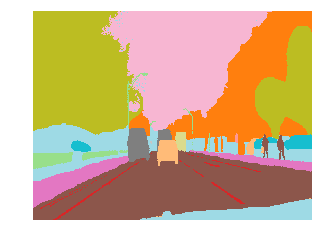

In [9]:
mask = open_mask(get_y_fn(img_f)) ## open_mask automatically colour codes for you
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          [26, 26, 26,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30]]]))

In [11]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes
##check position 4 building is building in pic above

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

Minute 2:03:35

In [12]:
size = src_size//4 ## // in pythin is integer divide / no half pixels
bs=1 ## decrease for your GPU as needed original = 8

In [13]:
## create a databunch via using the datablock API
src = (ImageFileList.from_folder(path_img)
       .label_from_func(get_y_fn)
       ## split _not_ randomly:given pics are frames from videos and next to each other to similar
       ## creators of dataset gave us with valid what needs to go to the validation set
       .split_by_fname_file('../valid.txt')) 

In [14]:
## from scr create the dataset
## classes=codes --> we have every pixel labelled with a number and this gives the list of what the no. mean
data = (src.datasets(SegmentationDataset, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True) ## transform the result as well
        .databunch(bs=bs) ## use smaller batch size
        .normalize(imagenet_stats)) ## normalise

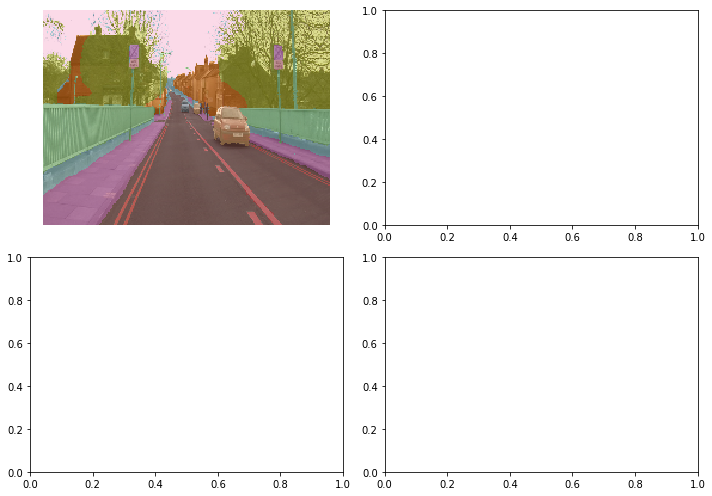

In [15]:
data.show_batch(2, figsize=(10,7))

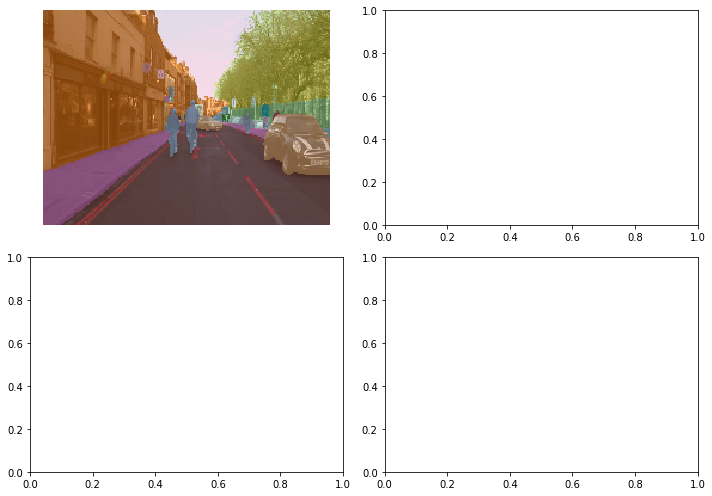

In [16]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

Video: Minute 1:46:30
Q&A:
- Can we use unsupervised learning to segment? Probably not to that quality 
- Can we make smaller data sets, 1st 64x64 to 128x128, 256x256. 'Progressive Resizing'
- Accuracy for pixel: per pixel simply, see details below for acc_camvid
- Correct how to?: if traing loss > validation loss? Underfitting
    - train longer
    - train last bit at lower learning rate
    - decrease regularisation (2nd part of course: weight decay, dropout, data augmentation)

U-Net Architecture: https://en.wikipedia.org/wiki/U-Net
- great for segmentation
- U-Net reverts downward path from convolutional networks and builds larger parts from the smaller parts that were created by the convnet
- most cited paper of that conference of all times

In [17]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']
## new metric, sometimes picture was labelled as void (for unknown reasons). In paper they say for
## reporting remove the voids
def acc_camvid(input, target):
    target = target.squeeze()
    mask = target != void_code ## so we take them out here
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [18]:
metrics=acc_camvid
# metrics=accuracy

In [20]:
##learn = Learner.create_unet(data, models.resnet34, metrics=metrics) ## fails cuda error
## explained in 2:09:30
    ## Mixed precision to avoid memory loss
    ## do 16 bits instead of 32
    ## should work twice as fast, avoids cuda errors
    ## might even deliver better results: often when less precise this delivers better results
learn = Learner.create_unet(data, models.resnet34, metrics=metrics).to_fp16()
## https://forums.fast.ai/t/lesson-3-camvid-half-precision-issue-to-fp16/29805
##learn.model.float()
##learn.show_results()

##learn.data.valid_dl.add_tfm(to_half)
##learn.show_results()

RuntimeError: CUDA error: out of memory

In [ ]:
##! nvidia-smi

In [ ]:
## Minite 1:56:10
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-2

In [ ]:
## fit_one_cycle makes the learning rate start low, go up and go down again
learn.fit_one_cycle(10, slice(lr))

why is fit_one_cycle a good idea?

https://forums.fast.ai/t/share-your-work-here/27676/300
https://gist.github.com/joshfp/85d96f07aaa5f4d2c9eb47956ccdcc88

- learning rate decreasing is an 'old' idea: the closer you get to the optimum the slower you' go 'learning rate annealing
- curves are often bumpy, so you need a learning rate high enough to jump over the bumps, but you still want 
the learning rate to go down at the end
- increase it right at the start: Lesley Smith
- if you gradually increase your learning rate you ensure not to get stuck in 'vallyes' of bumpy areas
- so if you gradually increase the learning rate you get to generalise very well and avoid local minima
- fit_one_cycle: you pass in a maximum learning rate
- plot losses: its just getting a little worse and then much better --> good !
- if it always goes down, you can bump up your learning rate a little
- https://arxiv.org/abs/1506.01186

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_lr()

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.unfreeze()

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lrs = slice(1e-5,lr/10)

In [ ]:
learn.fit_one_cycle(12, lrs)

In [ ]:
learn.save('stage-2');

## Go big

In [ ]:
## this is because above we used //2

size = src_size
bs=4 ## hals batch size, otherwise cuda gpu error

In [ ]:
data = (src.datasets(SegmentationDataset, classes=codes)
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = Learner.create_unet(data, models.resnet34, metrics=metrics)

In [ ]:
## this learner has the same weights as then above but the data is now the full image size
learn.load('stage-2');

In [ ]:
## this variation of u net works better than this important paper: https://arxiv.org/abs/1611.09326
## details on this U Net implementation will be explained in part2
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(12, lrs)